In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('Fraud Model.csv')

In [7]:
df['transaction_timestamp'] = pd.to_datetime(df['transaction_timestamp'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17962 entries, 0 to 17961
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   transaction_id            17962 non-null  object        
 1   merchant_id               17962 non-null  object        
 2   transaction_timestamp     17962 non-null  datetime64[ns]
 3   transaction_amount        17962 non-null  float64       
 4   merchant_avg_amount       17962 non-null  float64       
 5   merchant_std_amount       17949 non-null  float64       
 6   hour_of_day               17962 non-null  int64         
 7   is_weekend                17962 non-null  int64         
 8   time_since_last_tx_sec    17622 non-null  float64       
 9   merchant_age_days         17962 non-null  int64         
 10  is_early_lifecycle_tx     17962 non-null  int64         
 11  payment_method            17962 non-null  object        
 12  merchant_failure_r

In [10]:
df['merchant_std_amount'] = df['merchant_std_amount'].fillna(0)
df['time_since_last_tx_sec'] = df['time_since_last_tx_sec'].fillna(
    df['time_since_last_tx_sec'].median()
)

In [11]:
# Extract time features
df['hour'] = df['transaction_timestamp'].dt.hour
df['day_of_week'] = df['transaction_timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [13]:
# Calculate merchant's average transaction amount
merchant_avg = df.groupby('merchant_id')['transaction_amount'].mean().to_dict()
df['merchant_avg_amount'] = df['merchant_id'].map(merchant_avg)
df['amount_vs_avg'] = df['transaction_amount'] / df['merchant_avg_amount']

In [15]:
# Transaction velocity (how many transactions in last 5 minutes)
transactions = df.sort_values(['merchant_id', 'transaction_timestamp'])
transactions['prev_tx_time'] = df.groupby('merchant_id')['transaction_timestamp'].shift(1)

In [17]:
df['amount_to_avg_ratio'] = (
    df['transaction_amount'] / df['merchant_avg_amount']
)
df['z_score_amount'] = (
    (df['transaction_amount'] - df['merchant_avg_amount']) /
    df['merchant_std_amount']
)
df['rapid_repeat_tx'] = (df['time_since_last_tx_sec'] < 60).astype(int)
df['burst_tx'] = (df['time_since_last_tx_sec'] < 300).astype(int)

In [18]:
# One-hot encode payment method
df = pd.get_dummies(df, columns=['payment_method'], prefix='method')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17962 entries, 0 to 17961
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   transaction_id            17962 non-null  object        
 1   merchant_id               17962 non-null  object        
 2   transaction_timestamp     17962 non-null  datetime64[ns]
 3   transaction_amount        17962 non-null  float64       
 4   merchant_avg_amount       17962 non-null  float64       
 5   merchant_std_amount       17962 non-null  float64       
 6   hour_of_day               17962 non-null  int64         
 7   is_weekend                17962 non-null  int64         
 8   time_since_last_tx_sec    17962 non-null  float64       
 9   merchant_age_days         17962 non-null  int64         
 10  is_early_lifecycle_tx     17962 non-null  int64         
 11  merchant_failure_rate_7d  17962 non-null  float64       
 12  hour              

In [22]:
fraud_features = [
    'transaction_amount',
    'merchant_avg_amount',
    'is_weekend',
    'merchant_std_amount',
    'merchant_std_amount',
    'time_since_last_tx_sec',
    'hour_of_day',
    'merchant_age_days',
    'is_early_lifecycle_tx',
    'merchant_failure_rate_7d',
    'amount_to_avg_ratio',
    'z_score_amount',
    'rapid_repeat_tx',
    'burst_tx',
    'method_card',
    'method_ussd',
    'method_bank'
]

In [23]:
X_fraud = df[fraud_features].copy()

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler()

In [26]:
X_fraud_scaled = scaler.fit_transform(X_fraud)

In [27]:
print(f"Fraud detection dataset: {X_fraud.shape}")

Fraud detection dataset: (17962, 17)


In [28]:
from sklearn.ensemble import IsolationForest

In [29]:
iso_forest = IsolationForest(contamination=0.02, random_state=42, n_estimators=100)
iso_forest.fit(X_fraud_scaled)

IsolationForest(contamination=0.02, random_state=42)

In [30]:
df['anomaly_score'] = iso_forest.decision_function(X_fraud_scaled)
df['is_fraud'] = iso_forest.predict(X_fraud_scaled)
df['is_fraud'] = df['is_fraud'].map({1: 0, -1: 1})  # -1 = anomaly = fraud

In [31]:
fraud_tx = df[df['is_fraud'] == 1]

In [32]:
print(f"Total transactions: {len(df):,}")
print(f"Flagged as fraud: {len(fraud_tx):,} ({len(fraud_tx)/len(df):.2%})")
print(f"\nFraud transaction stats:")
print(f"  Avg amount: ₦{fraud_tx['transaction_amount'].mean():,.2f}")
print(f"  Normal avg: ₦{df[df['is_fraud']==0]['transaction_amount'].mean():,.2f}")
print(f"  Weekend %: {fraud_tx['is_weekend'].mean():.1%} vs {df['is_weekend'].mean():.1%}")

Total transactions: 17,962
Flagged as fraud: 360 (2.00%)

Fraud transaction stats:
  Avg amount: ₦44,088.33
  Normal avg: ₦40,730.94
  Weekend %: 47.8% vs 28.2%


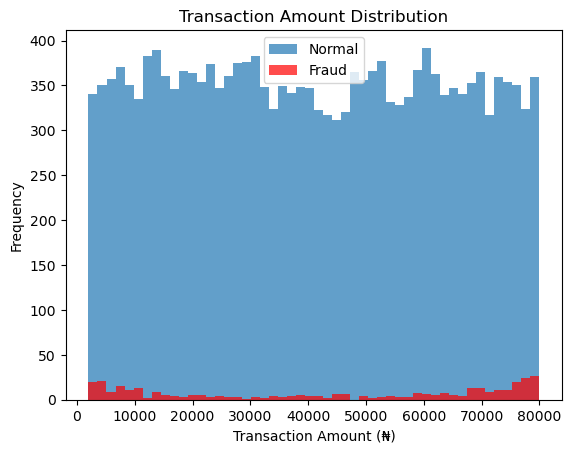

In [33]:
plt.hist(df[df['is_fraud']==0]['transaction_amount'], bins=50, alpha=0.7, label='Normal')
plt.hist(fraud_tx['transaction_amount'], bins=50, alpha=0.7, label='Fraud', color='red')
plt.xlabel('Transaction Amount (₦)')
plt.ylabel('Frequency')
plt.title('Transaction Amount Distribution')
plt.legend()
plt.savefig('fraud_patterns.png')
plt.show()

In [34]:
hours = range(24)

hour_normal = (
    df[df['is_fraud'] == 0]
    .groupby('hour_of_day')
    .size()
    .reindex(hours, fill_value=0)
)

hour_fraud = (
    fraud_tx
    .groupby('hour_of_day')
    .size()
    .reindex(hours, fill_value=0)
)

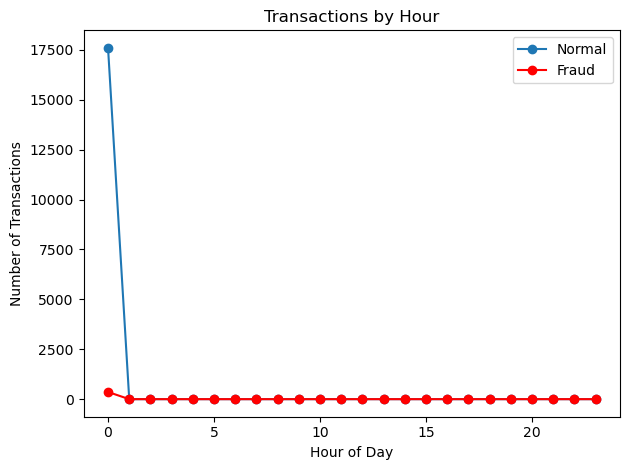

In [35]:
plt.plot(hours, hour_normal.values, label='Normal', marker='o')
plt.plot(hours, hour_fraud.values, label='Fraud', marker='o', color='red')

plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.title('Transactions by Hour')
plt.legend()
plt.tight_layout()
plt.savefig('fraud_hours.png')
plt.show()

In [36]:
high_risk_fraud = df[df['is_fraud'] == 1].sort_values('transaction_amount', ascending=False)

In [37]:
print("TOP 10 HIGH-RISK TRANSACTIONS:")
print(high_risk_fraud[['transaction_id', 'merchant_id', 'transaction_amount', 'hour_of_day']].head(10))

TOP 10 HIGH-RISK TRANSACTIONS:
       transaction_id   merchant_id  transaction_amount  hour_of_day
2099   t_1dee84d41b43  m_fddc0886be             79989.0            0
8180   t_733d3b6f884c  m_d0c2795faa             79919.0            0
11383  t_a1e69148b38b  m_823631e4b9             79916.0            0
14539  t_cf5ee08f0991  m_56a80ef3a4             79835.0            0
12320  t_af2980aa560c  m_3098bbde3c             79817.0            0
4512   t_3ee589c081a3  m_edfe8aac84             79764.0            0
7998   t_70aa2daedbba  m_edfe8aac84             79745.0            0
7858   t_6e9927c43f69  m_c57ae6c452             79718.0            0
6931   t_616f9b6dfd2a  m_d06f0a4803             79674.0            0
14828  t_d340417329cb  m_f09d23297b             79541.0            0


In [39]:
def compute_fraud_risk_score(df):
    score = np.zeros(len(df))

    # Rule 1: Amount far above merchant norm
    score += np.where(
        df['transaction_amount'] >
        df['merchant_avg_amount'] + 3 * df['merchant_std_amount'],
        40, 0
    )

    # Rule 2: Near platform limit
    score += np.where(
        df['transaction_amount'].between(75000, 99000),
        25, 0
    )

    # Rule 3: New merchant + high amount
    score += np.where(
        (df['merchant_age_days'] < 30) &
        (df['transaction_amount'] > 50000),
        15, 0
    )

    # Rule 4: Rapid succession
    score += np.where(
        (df['time_since_last_tx_sec'].notna()) &
        (df['time_since_last_tx_sec'] < 300),
        10, 0
    )

    # Rule 5: Merchant instability
    score += np.where(
        df['merchant_failure_rate_7d'] > 0.05,
        10, 0
    )

    return score

In [40]:
# Night flag (12am–4am)
df['is_night'] = df['hour_of_day'].between(0, 4).astype(int)

# Rapid succession: transactions < 5 minutes apart
df['rapid_succession'] = (
    df['time_since_last_tx_sec'].notna() &
    (df['time_since_last_tx_sec'] < 300)
).astype(int)

# First transaction flag
df['is_first_purchase'] = df['time_since_last_tx_sec'].isna().astype(int)

In [41]:
df['fraud_risk_score'] = 0

mask = df['is_fraud'] == 1
df.loc[mask, 'fraud_risk_score'] = compute_fraud_risk_score(df[mask])

In [42]:
def assign_fraud_action(score):
    if score >= 60:
        return 'BLOCK'
    elif score >= 40:
        return 'REVIEW'
    else:
        return 'APPROVE'

df['fraud_action'] = 'APPROVE'
df.loc[mask, 'fraud_action'] = (
    df.loc[mask, 'fraud_risk_score'].apply(assign_fraud_action)
)

In [43]:
df["fraud_flag"] = df["is_fraud"].astype(int)

In [44]:
df["merchant_fraud_flag"] = (
    df
    .groupby("merchant_id")["is_fraud"]
    .transform("max")
    .astype(int)
)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17962 entries, 0 to 17961
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   transaction_id            17962 non-null  object        
 1   merchant_id               17962 non-null  object        
 2   transaction_timestamp     17962 non-null  datetime64[ns]
 3   transaction_amount        17962 non-null  float64       
 4   merchant_avg_amount       17962 non-null  float64       
 5   merchant_std_amount       17962 non-null  float64       
 6   hour_of_day               17962 non-null  int64         
 7   is_weekend                17962 non-null  int64         
 8   time_since_last_tx_sec    17962 non-null  float64       
 9   merchant_age_days         17962 non-null  int64         
 10  is_early_lifecycle_tx     17962 non-null  int64         
 11  merchant_failure_rate_7d  17962 non-null  float64       
 12  hour              

In [46]:
df.to_csv("fraud_alert.csv", index=False)

In [48]:
!jupyter nbconvert --to python Fraud_Detection.ipynb

[NbConvertApp] Converting notebook Fraud_Detection.ipynb to python
[NbConvertApp] Writing 6578 bytes to Fraud_Detection.py
